In [3]:
from fastai.vision.all import *
from fastai.vision.widgets import *
path = untar_data(URLs.PASCAL_2012)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,2008_000002.jpg,tvmonitor,True
1,2008_000003.jpg,train person,True
2,2008_000007.jpg,boat,True
3,2008_000008.jpg,horse person,False
4,2008_000009.jpg,cow,True


In [5]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

In [6]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

In [7]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
# Create data for training
training_data = dblock.dataloaders(df)

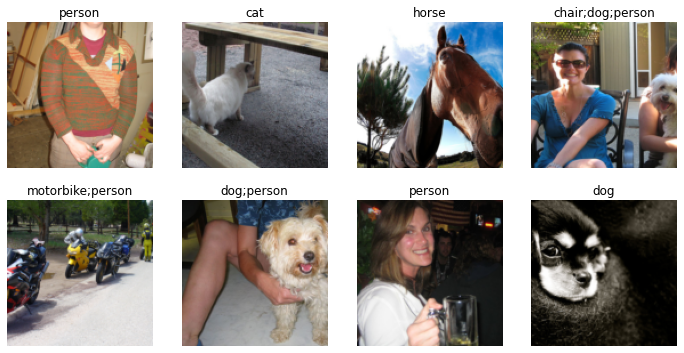

In [8]:
training_data.show_batch(nrows=2, ncols=4)

In [9]:
# Compute accuracy when `inp` and `targ` are the same size
def accuracy_multi(inp, targ, threshold=0.5, sigmoid=True):
    if sigmoid:
      # Apply a sigmoid on input
      inp = inp.sigmoid()
    return ((inp>threshold)==targ.bool()).float().mean()

In [10]:
learn = cnn_learner(training_data, resnet50, metrics=partial(accuracy_multi, threshold=0.2))
learn.fine_tune(3, base_lr=3e-3)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.619603,0.187245,0.848755,01:36


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.169906,0.113340,0.943414,01:38
1,0.123081,0.096856,0.955143,01:37
2,0.096081,0.091869,0.956990,01:37


In [11]:
# Export the neural network
learn.export('nn_desafio5.pkl')

In [12]:
# Threshold evaluation
preds,targs = learn.get_preds()
x = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, threshold=i, sigmoid=False) for i in x]

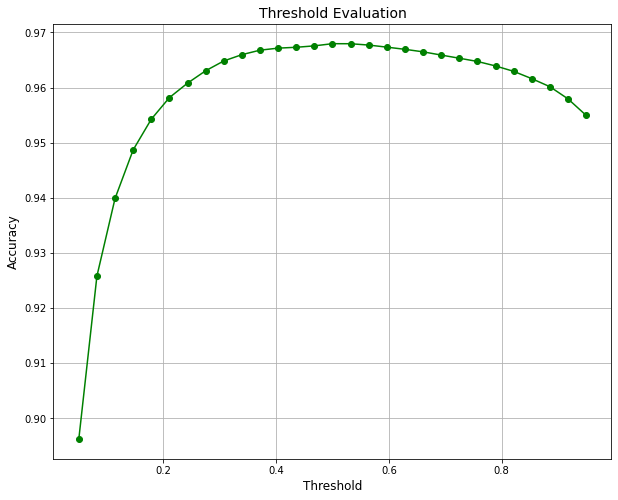

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.set_title('Threshold Evaluation', fontsize=14)
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.grid()
ax.plot(x, accs, '-og');